In [1]:
import argparse
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm, trange

# 读取数据
数据来源：scene

In [2]:
x_list = []
y_list = []
for pic in tqdm(os.listdir('scene')):
    pic_path = './scene/' + pic
    # 读取RGB三通道图像(640, 640, 3)
    pic_data = cv2.imread(pic_path, cv2.IMREAD_COLOR)
    pic_data = cv2.resize(pic_data, (640, 640))
    x_list.append(pic_data)
    y_list.append(int(pic[6:8]))
x_list = np.array(x_list)  # scene: (2500, 640, 1137, 3), object: (15000, 640, 640, 3)
y_list_int = np.array(y_list)

scene_label = pd.read_excel('scene_label.xlsx')
y_list = np.zeros((y_list_int.shape[0], 20))
for i in trange(y_list_int.shape[0]):
    y_list[i, scene_label[scene_label.id==y_list_int[i]].iloc[:, 1:].dropna(axis=1).astype(int).to_numpy()[0].tolist()] = 1

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

# 假设标签数据保存在label_list中，其中每个标签是一个整数
X = x_list
y = y_list

# 分层抽样，其中train_size和test_size分别表示训练集和测试集的比例
# n_splits表示抽取的次数，random_state表示随机数种子
split = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=42)
train_index, test_index = next(split.split(X, y))

# 得到训练集和测试集
X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

# 将训练集进一步划分为训练集和验证集，其中test_size表示验证集的比例
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, valid_index = next(split.split(X_train, y_train))

# 得到训练集、验证集和测试集的索引
train_index = [train_index[i] for i in range(len(train_index))]
valid_index = [valid_index[i] for i in range(len(valid_index))]
test_index = [test_index[i] for i in range(len(test_index))]

# 分类器

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from tqdm.notebook import tqdm, trange

# 定义超参数
batch_size = 8
learning_rate = 0.0001
num_epochs = 100

# 设置 GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# 加载数据集
train_data = x_list[train_index]
train_labels = y_list[train_index]
valid_data = x_list[valid_index]
valid_labels = y_list[valid_index]
test_data = x_list[test_index]
test_labels = y_list[test_index]

# # 定义数据增强和标准化
# # 在scene数据集中只做了标准化
transform = transforms.Compose([
#     transforms.RandomAffine(5),
#     transforms.ColorJitter(hue=.05, saturation=.05),
#     transforms.RandomCrop((88, 88)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
    transforms.ToTensor(), # 转换为张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 标准化张量
])

# 加载数据集
train_dataset = MyDataset(train_data, train_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = MyDataset(valid_data, valid_labels, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataset = MyDataset(test_data, test_labels, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# 定义模型
class MyModel(nn.Module):
    def __init__(self, num_classes=19):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=128 * 80 * 80, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
#         self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 80 * 80)
        x = F.relu(self.fc1(x))
#         x = self.dropout(x)
        x = self.fc2(x)
        return x

model = MyModel(num_classes=20)
# model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
writer = SummaryWriter()
writer.add_graph(model, input_to_model=torch.rand(batch_size, 3, 640, 640,).to(device))

In [ ]:
# 训练模型
for epoch in trange(num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print('Epoch [%d/%d], Loss: %.4f' % (epoch + 1, num_epochs, epoch_loss))
    torch.save(model.state_dict(), "./classifier/model-CNN-leakyrelu-scene/epoch-%d.pt" % epoch)
    writer.add_scalar('Loss/train', epoch_loss, epoch)

    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device), labels
            outputs = model(inputs)
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(valid_dataset)
        print('Loss of the model on the valid images: %f' % loss)
    writer.add_scalar('Loss/valid', epoch_loss, epoch)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/100], Loss: 10.1670


  0%|          | 0/50 [00:00<?, ?it/s]

Loss of the model on the valid images: 8.588871


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [2/100], Loss: 7.5190


  0%|          | 0/50 [00:00<?, ?it/s]

Loss of the model on the valid images: 7.337446


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [3/100], Loss: 6.2755


  0%|          | 0/50 [00:00<?, ?it/s]

Loss of the model on the valid images: 4.638095


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [4/100], Loss: 5.7667


  0%|          | 0/50 [00:00<?, ?it/s]

Loss of the model on the valid images: 5.780078


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [5/100], Loss: 5.4898


  0%|          | 0/50 [00:00<?, ?it/s]

Loss of the model on the valid images: 5.996552


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [6/100], Loss: 5.3365


  0%|          | 0/50 [00:00<?, ?it/s]

Loss of the model on the valid images: 5.007970


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [7/100], Loss: 5.2332


  0%|          | 0/50 [00:00<?, ?it/s]

Loss of the model on the valid images: 4.813715


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [8/100], Loss: 5.1673


  0%|          | 0/50 [00:00<?, ?it/s]

Loss of the model on the valid images: 3.832993


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [9/100], Loss: 5.1234


  0%|          | 0/50 [00:00<?, ?it/s]

Loss of the model on the valid images: 4.158244


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10/100], Loss: 5.1087


  0%|          | 0/50 [00:00<?, ?it/s]

Loss of the model on the valid images: 4.804686


  0%|          | 0/200 [00:00<?, ?it/s]

# 评价

In [17]:
y_pred = []
y_true = []
# 测试模型（这里是针对单个杯子设计的准确率，多个杯子需修改代码）
model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        outputs = model(inputs)
        predicted = np.int64(np.array(outputs) > 0)
        y_pred.append(predicted)
        y_true.append(np.int64(np.array(labels)))

  0%|          | 0/63 [00:00<?, ?it/s]

In [18]:
y_pred = np.row_stack(y_pred)
y_true = np.row_stack(y_true)

In [19]:
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score

# 计算混淆矩阵
mcm = multilabel_confusion_matrix(y_true, y_pred)

# 计算精确度、召回率和F1分数
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')
f1 = f1_score(y_true, y_pred, average='micro')

# 打印结果
print("Multilabel Confusion Matrix:")
print(mcm)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Multilabel Confusion Matrix:
[[[459   1]
  [  2  38]]

 [[356   4]
  [  4 136]]

 [[371   9]
  [  9 111]]

 [[393   7]
  [  9  91]]

 [[394   6]
  [  7  93]]

 [[437   3]
  [  6  54]]

 [[373   7]
  [  8 112]]

 [[286  14]
  [  2 198]]

 [[378   2]
  [  1 119]]

 [[391   9]
  [  3  97]]

 [[368  12]
  [  7 113]]

 [[376   4]
  [  2 118]]

 [[480   0]
  [  5  15]]

 [[435   5]
  [  0  60]]

 [[408  12]
  [  1  79]]

 [[456   4]
  [  0  40]]

 [[397   3]
  [  1  99]]

 [[431   9]
  [  1  59]]

 [[452   8]
  [  0  40]]

 [[409  11]
  [  0  80]]]
Precision: 0.9309245483528161
Recall: 0.9626373626373627
F1 Score: 0.946515397082658


# 绘制中间特征层

In [11]:
path = './classifier/model-CNN-scene/epoch-99.pt'
trained_state_dict = torch.load(path)
model.load_state_dict(trained_state_dict, strict=False)

<All keys matched successfully>

In [128]:
class Hook(object):
    def __init__(self):
        self.module_name = []
        self.features_in_hook = []
        self.features_out_hook = []

    def __call__(self, module, fea_in, fea_out):
        print("hooker working", self)
        self.module_name.append(module.__class__)
        self.features_in_hook.append(fea_in)
        self.features_out_hook.append(fea_out)
        return None
    
hh = Hook()
model.eval()
model.conv3.register_forward_hook(hh)

inputs = test_dataset[0][0]
outputs = model(inputs)

hooker working <__main__.Hook object at 0x7f3324b916d0>
hooker working <__main__.Hook object at 0x7f3325775dc0>
hooker working <__main__.Hook object at 0x7f33257cfbe0>
hooker working <__main__.Hook object at 0x7f3324adf460>
hooker working <__main__.Hook object at 0x7f33248b9550>
hooker working <__main__.Hook object at 0x7f3324710be0>
hooker working <__main__.Hook object at 0x7f3323aa3eb0>


[<class 'torch.nn.modules.linear.Linear'>]
torch.Size([1, 819200])
torch.Size([1, 512])


TypeError: Invalid shape (512,) for image data

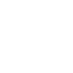

In [129]:
print(hh.module_name)
print((hh.features_in_hook[0][0].shape))
print((hh.features_out_hook[0].shape))

out1 = hh.features_out_hook[0]
total_ft  = out1.shape[0]
first_item = out1.cpu().clone()    

plt.figure(figsize=(10, 5))
for ftidx in range(min(total_ft, 32)):
    ft = first_item[ftidx]
    plt.subplot(4, 8, ftidx + 1) 
    plt.axis('off')
    plt.imshow(ft.detach(), cmap='gray')
plt.savefig('conv3.pdf', bbox_inches='tight')

In [95]:
model

MyModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=819200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=20, bias=True)
)

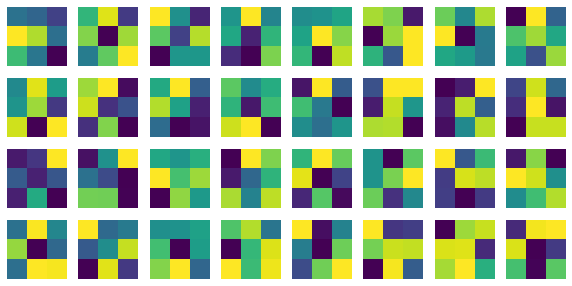

In [146]:
plt.figure(figsize=(10, 5))
for ftidx in range(32):
    plt.subplot(4, 8, ftidx + 1)
    plt.axis('off')
    plt.imshow(trained_state_dict['conv1.weight'].cpu()[ftidx].numpy()[0])
plt.savefig('conv1_kernel.pdf', bbox_inches='tight')

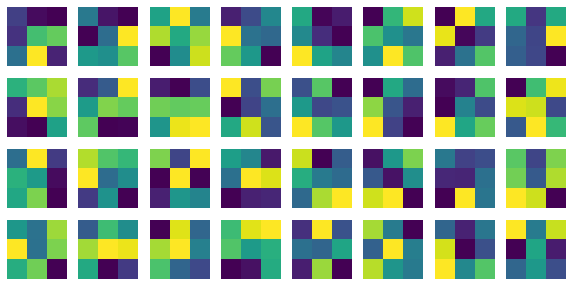

In [147]:
plt.figure(figsize=(10, 5))
for ftidx in range(32):
    plt.subplot(4, 8, ftidx + 1)
    plt.axis('off')
    plt.imshow(trained_state_dict['conv2.weight'].cpu()[ftidx].numpy()[0])
plt.savefig('conv2_kernel.pdf', bbox_inches='tight')

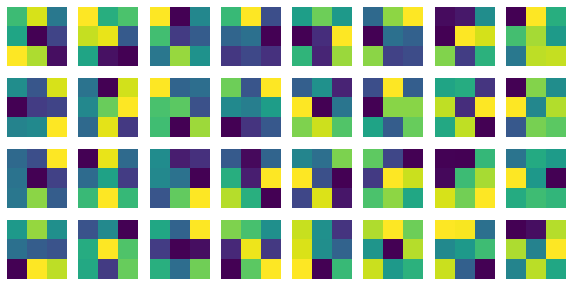

In [148]:
plt.figure(figsize=(10, 5))
for ftidx in range(32):
    plt.subplot(4, 8, ftidx + 1)
    plt.axis('off')
    plt.imshow(trained_state_dict['conv3.weight'].cpu()[ftidx].numpy()[0])
plt.savefig('conv3_kernel.pdf', bbox_inches='tight')

In [153]:
torch.save(model.state_dict(), "model.pt")

In [ ]:
# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=class_names)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:3], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])